In [46]:
%matplotlib inline
import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import (MinMaxScaler, RobustScaler)
from sklearn.ensemble import (RandomForestRegressor, IsolationForest)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from sklearn.neural_network import MLPRegressor

from fancyimpute import KNN,  SoftImpute, IterativeImputer, BiScaler, MatrixFactorization
import util.data
rng = np.random.RandomState(42)
n_features_to_use = 50


In [6]:
train_data, test_data = util.data.load()
# Define dictionary to store our rankings
ranks = {}

# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

Training Data: 
  Amount of features: 888
  Amount of observations: 1212
  Min age: 42.0 Max age: 96.0

Test Data: 
  Amount of observations: 776


In [9]:
X_incomplete = train_data.drop(["id", "y"], axis=1).values
# use mean values
train_mean_values = train_data.mean()
train_data_mean =  train_data.fillna(train_mean_values)
test_data_mean = test_data.fillna(train_mean_values)
X = train_data_mean.drop(["id", "y"], axis=1).values
X_test = test_data_mean.drop(["id"], axis=1).values
y = train_data["y"].values

# remove outliers 
isoForest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
outliers = isoForest.fit_predict(X)

X = X[np.where(outliers > 0)]
y = y[np.where(outliers > 0)]

# scale the data
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X_test = transformer.transform(X_test)

# selected most important features
colnames = train_data.drop(["id", "y"], axis=1).columns

rlasso = RandomizedLasso(alpha=0.04)
lr = LinearRegression(normalize=True)
ridge = Ridge(alpha = 7)
lasso = Lasso(alpha=.05)
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50)

rlasso.fit(X, y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print("rLasso done")
# Construct our Linear Regression model

lr.fit(X, y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)
print("LinReg done")

#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1 )
rfe.fit(X, y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
print("RFE done")

ridge.fit(X,y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)
print("Ridge done")

lasso.fit(X, y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)
print("Lasso done")

rf.fit(X, y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);
print("RF done")

# Create empty dictionary to store the mean value calculated from all the scores
r = {}
meanplot = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)




/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


rLasso done
LinReg done
RFE done
Ridge done


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso done
RF done


In [31]:
n_features_to_use = 50
feature_list = list(meanplot.head(n_features_to_use)["Feature"].values)
X_reduced_dim = pd.DataFrame(X, columns=colnames)
X_reduced_dim = X_reduced_dim[feature_list]

X_test_reduced_dim = pd.DataFrame(X_test, columns=colnames)
X_test_reduced_dim = X_test_reduced_dim[feature_list]

X_reduced_dim["y"] = y

In [27]:
# create model
model = Sequential()
model.add(Dense(n_features_to_use, input_dim=n_features_to_use, init='RandomUniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(50, init='RandomUniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(100, init='RandomUniform'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, init='RandomUniform', activation='sigmoid'))
# Compile model
optimizer = Adam(lr=0.000005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_absolute_error', optimizer=optimizer)



/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, input_dim=40, kernel_initializer="RandomUniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, kernel_initializer="RandomUniform")`
  """
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="RandomUniform")`
  import sys
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="RandomUniform")`
  if __name__ == '__main__':


# load test data and compute same preprocessin steps

In [29]:
model.fit(x=X_reduced_dim.drop(["y"], axis=1).as_matrix(), 
          y=X_reduced_dim["y"].values / 100.0, epochs=150, 
          verbose=1, 
          validation_split=0.1, 
          shuffle=True, 
          steps_per_epoch=100, initial_epoch=0, validation_steps=10)
    # calculate predictions
    
predictions = model.predict(X_test_reduced_dim.as_matrix()) * 100.0
    
     

Train on 1088 samples, validate on 121 samples
Epoch 1/150
 44/100 [============>.................] - ETA: 0s - loss: 0.0505

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


100/100 [==============================] - 0s 4ms/step - loss: 0.0505 - val_loss: 0.0563
Epoch 2/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0563
Epoch 3/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0563
Epoch 4/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0563
Epoch 5/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0563
Epoch 6/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0563
Epoch 7/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0563
Epoch 8/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0563
Epoch 9/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0563
Epoch 10/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0563
E

100/100 [==============================] - 0s 4ms/step - loss: 0.0443 - val_loss: 0.0557
Epoch 82/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0443 - val_loss: 0.0557
Epoch 83/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0556
Epoch 84/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0441 - val_loss: 0.0556
Epoch 85/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0556
Epoch 86/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0440 - val_loss: 0.0556
Epoch 87/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0556
Epoch 88/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0556
Epoch 89/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0438 - val_loss: 0.0555
Epoch 90/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


# Save predictions

In [30]:
submission =  pd.DataFrame(data={"id": list(range(776)), "y": np.squeeze(list(predictions))}) 
submission.to_csv("submissions/mean_NN_f{}.csv".format(n_features_to_use), index= False)

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs

1
2
3
4


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


5
6


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


7
8


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


9


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


11


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


12


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


13


[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


14


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


15


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


17


[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


18


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


19


[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


21


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


22


[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


23


[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


24


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


25


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


26


[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


27


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


28


[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


29


[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


31


[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


32


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


33


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


34


[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


35


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


36


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


37


[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


38


[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


39


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


41


[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


42


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


43


[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


44


[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


45


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


46


[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


47


[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


49


[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


51


[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


52


[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


53


[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


54


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


55


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


56


[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


57


[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


58


[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


59


[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


61


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


62


[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


63


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


64


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


65


[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


66


[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


67


[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


68


[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


69


[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


72


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


75


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


76


[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


77


[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


80


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


81


[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


82


[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


83


[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


84


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


85


[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


86


[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


87


[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


88


[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


89


[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


90


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


91


[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


92


[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


93


[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


94


[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


95


[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


96


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


97


[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


98


[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


99


[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.0s finished


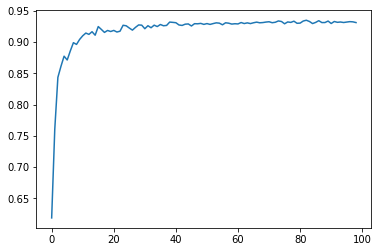

In [41]:
rf_X = X_reduced_dim.drop(["y"], axis=1).as_matrix()
rf_y = X_reduced_dim["y"].values
scores = []
for i in range(1, 100):
    print(i)
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=i, verbose=1)
    rf.fit(rf_X, rf_y)
    scores.append(rf.score(rf_X, rf_y))
    
plt.plot(scores)


In [42]:
print(np.argmax(scores))

82


In [45]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=25, verbose=1)
rf.fit(rf_X, rf_y)

y_pred = rf.predict(X_test_reduced_dim.as_matrix())
submission =  pd.DataFrame(data={"id": list(range(776)), "y": y_pred}) 
submission.to_csv("submissions/mean_RFR25_f{}.csv".format(n_features_to_use), index= False)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [83]:
mlp_scores = []
index = 0
for i in range(10, 50):
    mlp_scores.append([])
    print(i)
    for j in range(1, 50):
    
        modelMLP = MLPRegressor(learning_rate='constant', 
                                 hidden_layer_sizes=(i, j),
                                 activation='logistic', 
                                 learning_rate_init=0.001,
                                 max_iter=15000, 
                                 random_state=42,
                                 early_stopping =True,
                                 validation_fraction=0.1,
                                 tol=0.00000000001,
                                 alpha=0.1,
                                 #n_iter_no_change=100,
                                 verbose=False)
        modelMLP.fit(rf_X, rf_y)
        mlp_scores[index].append(modelMLP.best_validation_score_)
    index = index + 1




10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [91]:
min_index = []
for i in range(0, 40):
    min_index.append(np.max(mlp_scores[i]))

min_i = np.argmax(min_index)
min_j = np.argmax(mlp_scores[min_i])

print('i={}, j={}, val={}'.format(min_i, min_j, mlp_scores[min_i][min_j]))

i=4, j=37, val=0.6542349024019642


In [92]:
modelMLP = MLPRegressor(learning_rate='constant', 
                             hidden_layer_sizes=(4, 37),
                             activation='logistic', 
                             learning_rate_init=0.001,
                             max_iter=15000, 
                             random_state=42,
                             early_stopping =True,
                             validation_fraction=0.1,
                             tol=0.00000000001,
                             alpha=0.1,
                             #n_iter_no_change=100,
                             verbose=False)
modelMLP.fit(rf_X, rf_y)
y_pred = modelMLP.predict(X_test_reduced_dim.as_matrix())
submission =  pd.DataFrame(data={"id": list(range(776)), "y": y_pred}) 
submission.to_csv("submissions/mean_MP_4_37_f{}.csv".format(n_features_to_use), index= False)

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
